In [44]:
%matplotlib inline

In [45]:
import os
path = os.path.abspath(os.getcwd())

In [46]:
import math
import numpy as np
import pandas as pd

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from fitter import Fitter

from scipy import fft
from scipy.optimize import curve_fit, minimize
from scipy.stats import kstest, norm, laplace, entropy, cauchy, entropy
from sklearn.feature_selection import mutual_info_regression

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pylab as py

In [47]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('ggplot')

In [48]:
pd.set_option("display.max_colwidth",100)

In [49]:
# OPTIONS

all_data_files = [
     'moduntu_HP_desktop_trace_idle_22.12.14_6h',
     'moduntu_HP_desktop_trace_idle_22.12.15_20h',
     'moduntu_HP_desktop_trace_no-wifi_22.12.16_19h',
     'moduntu_HP_server_trace_idle_22.12.21_16h',
     'moduntu_HP_server_trace_no-wifi_22.12.20_16h',
     'moduntu_RPi_server32_trace_no-peri_23.01.19_17h',
     'moduntu_RPi_server32_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_desktop_trace_idle_22.11.15_1h',
     'moduntu_VM_desktop_trace_idle_22.12.13_12h',
     'moduntu_VM_desktop_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_server_trace_idle_22.12.13_9h',
     'moduntu_VM_server_trace_no-wifi_23.01.18_14h']

data_files = [  
     'moduntu_HP_desktop_trace_no-wifi_22.12.16_19h',
     'moduntu_HP_server_trace_no-wifi_22.12.20_16h',
     'moduntu_RPi_server32_trace_no-peri_23.01.19_17h',
     'moduntu_VM_desktop_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_server_trace_no-wifi_23.01.18_14h']

# I - Data formatting
## 1) Text to CSV

## 2) Data import

In [50]:
filename = data_files[2]
data_path = path + "\\csv\\" + filename + ".csv"
data = pd.read_csv(data_path).drop('count', axis=1)
data.head(5)

,input1,input2,source_id,idle
0,3710067642,4112549988,0,True
1,3710069328,4112549988,0,True
2,3718701703,3995109476,0,True
3,3748940765,3709896804,0,True
4,3766219786,4112549988,0,True


In [51]:
data[data["idle"]==True]

,input1,input2,source_id,idle
0,3710067642,4112549988,0,True
1,3710069328,4112549988,0,True
2,3718701703,3995109476,0,True
3,3748940765,3709896804,0,True
4,3766219786,4112549988,0,True
...,...,...,...,...
417098,599194526,4112549988,0,True
417099,599196285,4112549988,0,True
417100,599197991,4112549988,0,True
417101,599199694,4112549988,0,True


In [52]:
data.dtypes

input1       int64
input2       int64
source_id    int64
idle          bool
dtype: object

In [53]:
def get_stats(data, col):
    print("Stats for " + col + " :")
    stats = data[col].value_counts()
    stats_perc = data[col].value_counts(normalize = True)
    
    total = 0
    for i in range(len(stats)):
        total = stats[i]
    
    for i in range(len(stats)):
        print(str(stats.index[i]) + "\t\t", str(stats[stats.index[i]]) + 
              '\t\t', str(round(stats_perc[stats.index[i]] * 100)) + '%')
        
    print()

In [54]:
for filename in data_files:
    print(filename)

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h
moduntu_HP_server_trace_no-wifi_22.12.20_16h
moduntu_RPi_server32_trace_no-peri_23.01.19_17h
moduntu_VM_desktop_trace_no-wifi_23.01.18_14h
moduntu_VM_server_trace_no-wifi_23.01.18_14h


In [55]:
source_id_0, idle_true, count = 0,0,0
for filename in data_files:
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    count += data.shape[0] 
    stats = data["source_id"].value_counts()
    source_id_0 += stats[0]
    stats = data["idle"].value_counts()
    idle_true += stats[True]
    
    print(filename)
    for col in ["source_id", "idle"]:
        get_stats(data, col)

print(count, source_id_0, source_id_0/count, idle_true, idle_true/count)

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h
Stats for source_id :
0		 4241501		 100%
1		 238		 0%

Stats for idle :
True		 4218471		 99%
False		 23268		 1%

moduntu_HP_server_trace_no-wifi_22.12.20_16h
Stats for source_id :
0		 3017549		 100%
1		 280		 0%

Stats for idle :
True		 3014779		 100%
False		 3050		 0%

moduntu_RPi_server32_trace_no-peri_23.01.19_17h
Stats for source_id :
0		 417103		 100%

Stats for idle :
True		 409318		 98%
False		 7785		 2%

moduntu_VM_desktop_trace_no-wifi_23.01.18_14h
Stats for source_id :
0		 67140		 99%
1		 844		 1%

Stats for idle :
True		 40042		 59%
False		 27942		 41%

moduntu_VM_server_trace_no-wifi_23.01.18_14h
Stats for source_id :
0		 263785		 100%
1		 288		 0%

Stats for idle :
True		 246573		 93%
False		 17500		 7%

8008728 8007078 0.999793974773522 7929183 0.9900677111271603


## 3) Selecting source

Possible values for source_id:
 * 0 for interrupts
 * 1 for timing

In [56]:
data_select = data[data.source_id == 0] 
data_select = data_select[data_select.idle == True]

print("Fom", data.shape, "to", data_select.shape)

Fom (264073, 5) to (246287, 5)


In [57]:
def does_increment(df, columns):
    for col in columns:
        y = df[col].to_numpy()
        y =  y - np.roll(y.copy(), 1)
        y[0] = 0
        y = y < 0
        df.loc[:, col] = y
    
data.shape

(264073, 5)

In [58]:
data_test = data[data.source_id == 0]
data_test = data_test[data_test.idle == True] 
does_increment(data_test, ['input2'])

sum(data_test.input2)

0

# II - Direct analysis
## 1) Density visualization

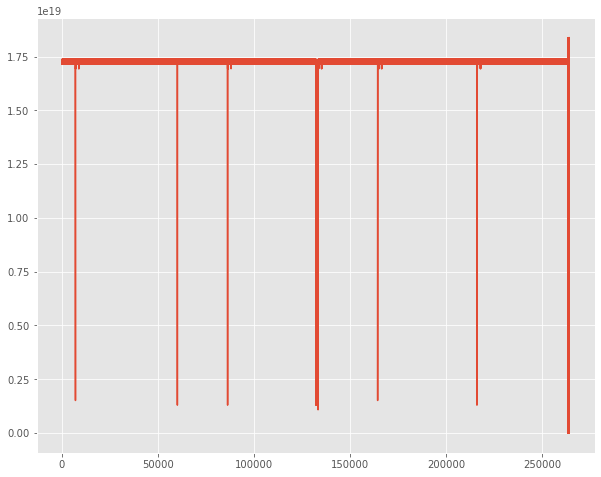

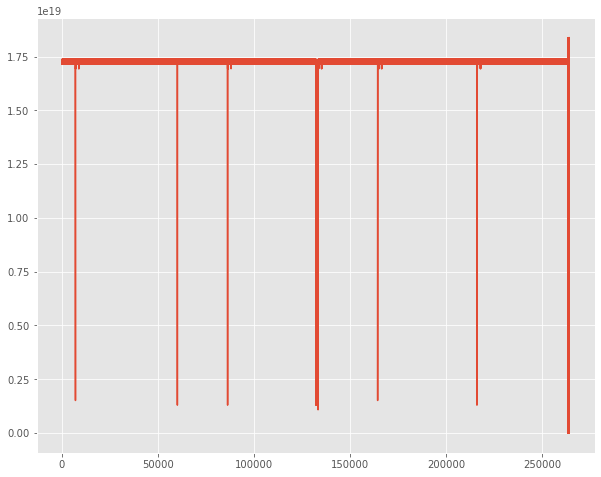

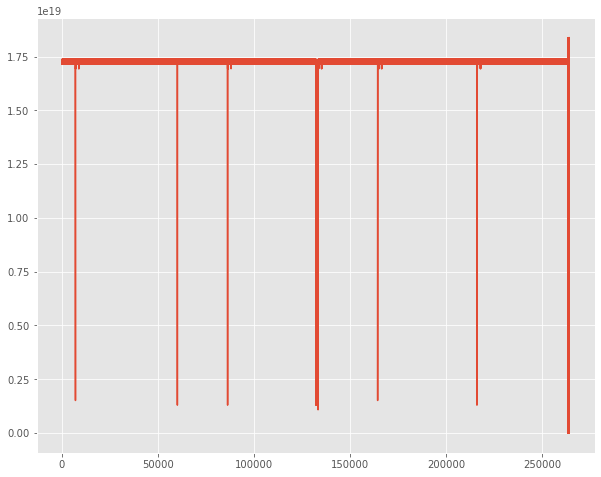

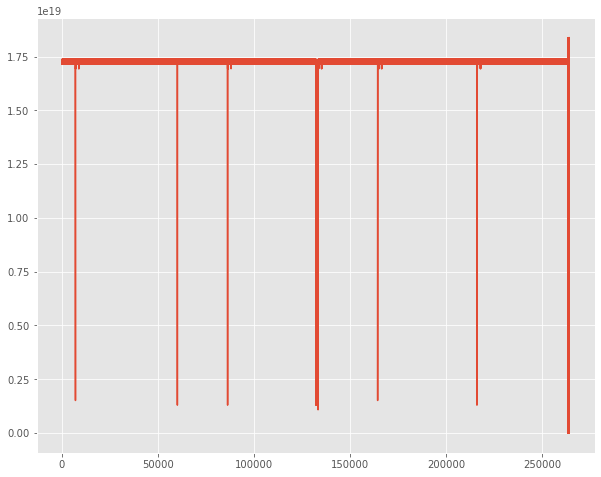

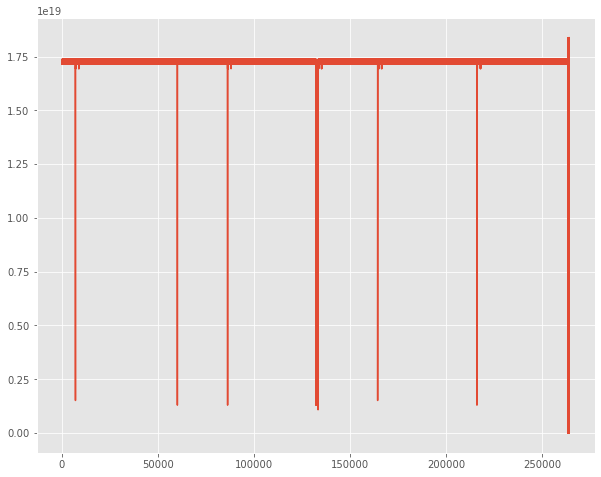

In [59]:
for file in data_files:
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    fig, ax = plt.subplots()
    ax.plot(data.input2)

In [60]:
def tup_string(selection):
    tup_str = ""
    for tup in selection:
        if not tup_str == "":
            tup_str += ", "
        tup_str += str(tup[0]) + " = " + str(tup[1])
    return tup_str

In [61]:
def data_hist(filename, column, selection = [], crop = (None, None), slicer = (None, None), log = False, bins = None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 

    # Cropping: remove crop[0] % of beginning or crop[0] of end of the data (if not idle)
    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))
    
    x = data[column]
    bins = int(np.sqrt(len(x))) if bins==None else bins
    
    hist, bin_edges = np.histogram(x, bins=bins) 
    prob = hist / np.sum(hist)
    entropy = -np.sum(prob * np.log2(prob + (prob==0)))
    min_entropy = -np.log2(np.max(prob))
    
    fig, ax = plt.subplots()
    plt.hist(x, density=True,  log = log, bins = bins)
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if not crop[0] else int(crop[0]*n))+",", str(0 if not crop[1] else int(crop[1]*n)))
    print("\t min-entropy:", min_entropy)
    print("\t entropy:", entropy)
    print("\t # of elements:", str(data.shape[0]))
    print("\t # of bins:", str(bins))
    print("\t log =", str(log))
    
    ax.set_xlabel(u'Timestamp value')
    ax.set_ylabel('Frequency')

    plt.show()

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: 
	 crop values: 0, 0
	 min-entropy: 0.06671506501451925
	 entropy: 0.4311381957308367
	 # of elements: 4241739
	 # of bins: 2059
	 log = True


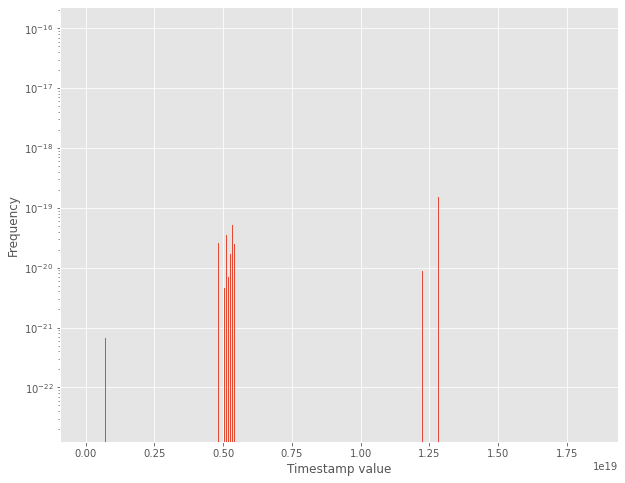

Histogram of moduntu_HP_server_trace_no-wifi_22.12.20_16h :
	 selection: 
	 crop values: 0, 0
	 min-entropy: 0.00465997104678559
	 entropy: 0.04508736087184665
	 # of elements: 3017829
	 # of bins: 1737
	 log = True


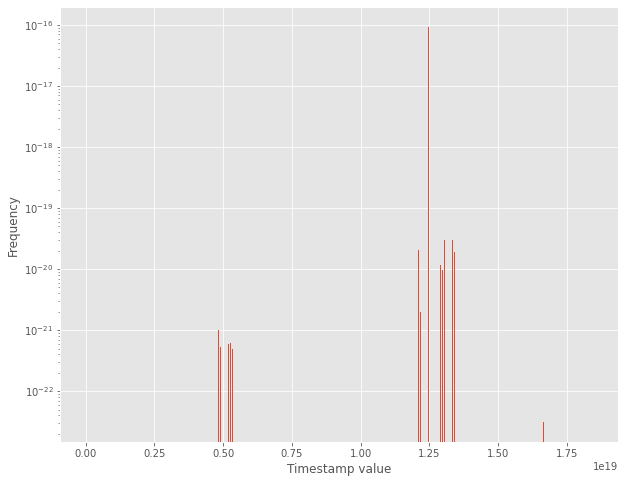

Histogram of moduntu_RPi_server32_trace_no-peri_23.01.19_17h :
	 selection: 
	 crop values: 0, 0
	 min-entropy: 0.45266385575792684
	 entropy: 1.1498961294128962
	 # of elements: 417103
	 # of bins: 645
	 log = True


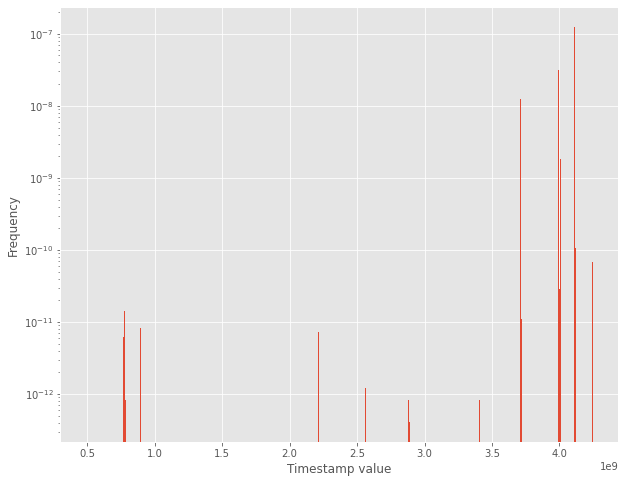

Histogram of moduntu_VM_desktop_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 0, 0
	 min-entropy: 0.23882590693353561
	 entropy: 0.9245053813482922
	 # of elements: 67984
	 # of bins: 260
	 log = True


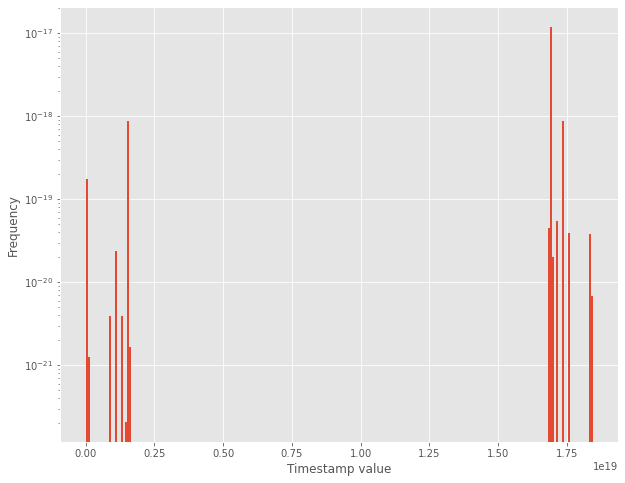

Histogram of moduntu_VM_server_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 0, 0
	 min-entropy: 0.28278309459186396
	 entropy: 0.7364290778365393
	 # of elements: 264073
	 # of bins: 513
	 log = True


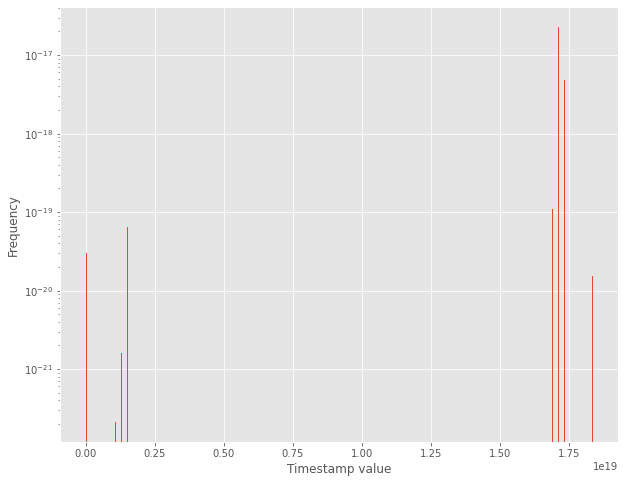

In [62]:
for file in data_files:
    data_hist(file, 'input2', selection = [], crop = (0, 0), slicer = (None, None), 
              log = True, bins = None)

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: source_id = 0, idle = True
	 crop values: 843647, 843647
	 min-entropy: 0.02239701810549503
	 entropy: 0.12683631131421863
	 # of elements: 2530941
	 # of bins: 1590
	 log = False


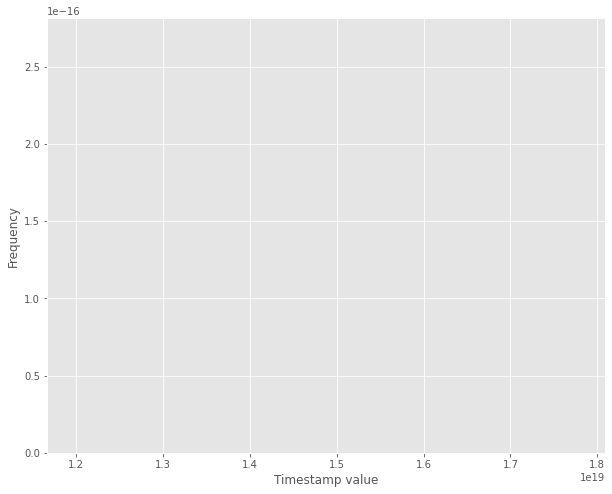

Histogram of moduntu_HP_server_trace_no-wifi_22.12.20_16h :
	 selection: source_id = 0, idle = True
	 crop values: 602899, 602899
	 min-entropy: 0.0007068835485866704
	 entropy: 0.00741268594297438
	 # of elements: 1808701
	 # of bins: 1344
	 log = False


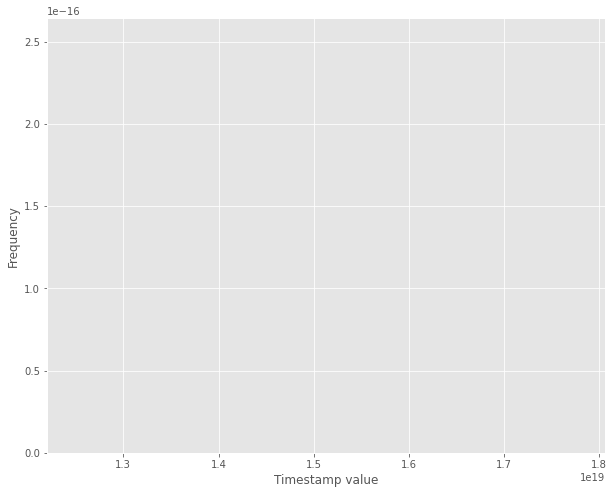

Histogram of moduntu_RPi_server32_trace_no-peri_23.01.19_17h :
	 selection: source_id = 0, idle = True
	 crop values: 81863, 81863
	 min-entropy: 0.4263684775432526
	 entropy: 1.0485018649804974
	 # of elements: 245592
	 # of bins: 495
	 log = False


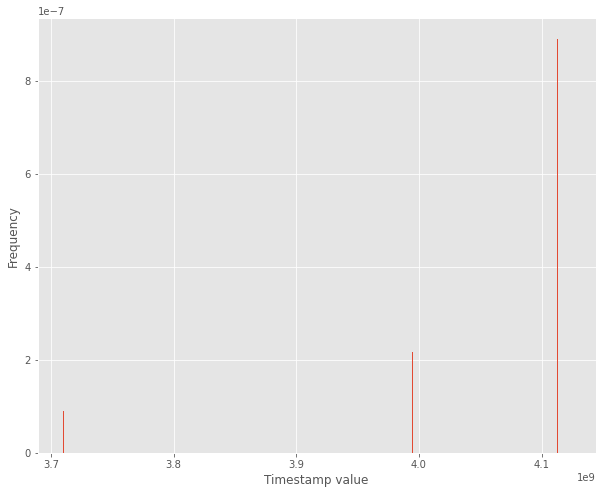

Histogram of moduntu_VM_desktop_trace_no-wifi_23.01.18_14h :
	 selection: source_id = 0, idle = True
	 crop values: 7856, 7856
	 min-entropy: 0.18880245346438904
	 entropy: 0.5548436914769235
	 # of elements: 23568
	 # of bins: 153
	 log = False


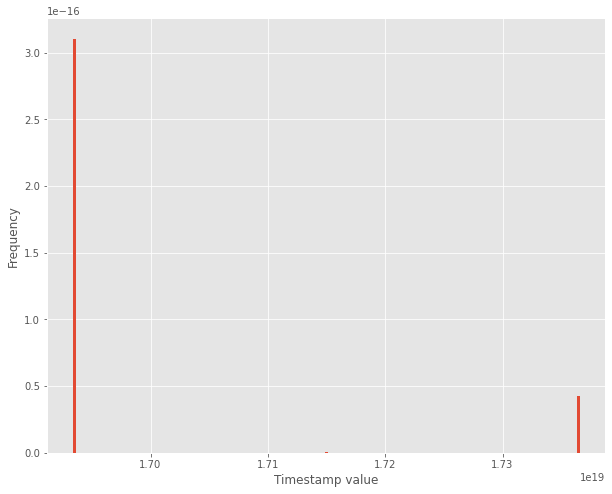

Histogram of moduntu_VM_server_trace_no-wifi_23.01.18_14h :
	 selection: source_id = 0, idle = True
	 crop values: 49257, 49257
	 min-entropy: 0.24836141816354962
	 entropy: 0.6749597093495306
	 # of elements: 147773
	 # of bins: 384
	 log = False


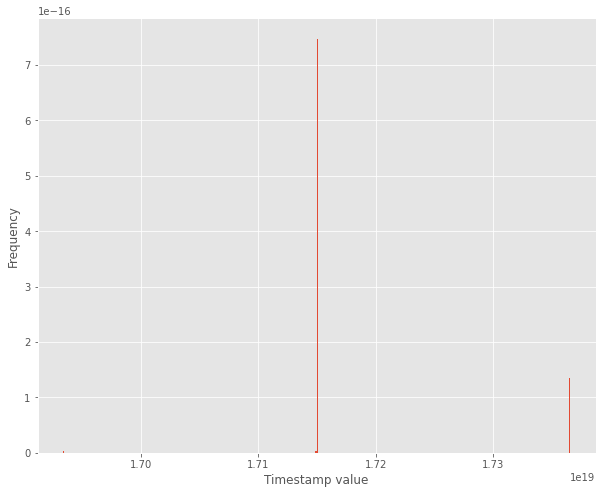

In [20]:
for file in data_files:
    data_hist(file, 'input2', selection = [('source_id', 0), ('idle', True)], crop = (0.2, 0.2), slicer = (None, None), 
              log = False, bins = None)

## 2) Direct modelling

In [21]:
for file in data_files:
    print(file)
    data_path = path + "\\csv\\" + file + ".csv"
    data = pd.read_csv(data_path)
    value_counts = data['input2'].value_counts()
    probabilities = value_counts / len(data)
    print(probabilities.head(20))
    print()

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h
11961560608430405726    0.953942
12033618202468333662    0.013451
12898309330923468894    0.004216
13330654895151036510    0.003636
13114482113037252702    0.002954
13618885271302748254    0.002831
17726168131464640606    0.002639
13042424518999324766    0.002225
13186539707075180638    0.001509
12826251736885540958    0.001261
12970366924961396830    0.001069
13258597301113108574    0.000835
13546827677264820318    0.000803
13474770083226892382    0.000734
11961560608437960837    0.000650
13402712489188964446    0.000434
12033618202475888773    0.000298
17798225725502568542    0.000089
14915921963985451102    0.000065
12249790984582117470    0.000063
Name: input2, dtype: float64

moduntu_HP_server_trace_no-wifi_22.12.20_16h
12465963766565877854    0.995749
12465963766573432965    0.000795
13042424518869301342    0.000235
12105675796376238174    0.000205
17798225725372545118    0.000190
13330654895021013086    0.000178
12826251736755517534 

In [45]:
for file in data_files:
    print(file)
    data_path = path + "\\csv\\" + file + ".csv"
    data = pd.read_csv(data_path)
    unique_values = data['input2'].nunique()
    print(unique_values)
    print()

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h
12327

moduntu_HP_server_trace_no-wifi_22.12.20_16h
1874

moduntu_RPi_server32_trace_no-peri_23.01.19_17h
599

moduntu_VM_desktop_trace_no-wifi_23.01.18_14h
5096

moduntu_VM_server_trace_no-wifi_23.01.18_14h
1249



## 3) Independence of inputs
### A/ Autocorrelation coefficient

In [22]:
def fft_autocorr(x):
    x = np.asarray(x)
    N = len(x)
#     x = x-x.mean()
    s = fft.fft(x, N*2-1)
    result = np.real(fft.ifft(s * np.conjugate(s), N*2-1))
    result = result[:N]
    result /= result[0]
    return np.array(result.astype(float))

def maple_autocorr(x): 
    x = np.asarray(x)
#     y = x-x.mean()
    y = x / max(x)
    
    autocorr = np.correlate(y, y, mode='full').astype(float)
#     autocorr = np.correlate(y, y, mode='same').astype(float)
    autocorr = autocorr[len(autocorr)//2:]
    
    
    autocorr /= autocorr[0]
    return np.array(autocorr.astype(float))

autocorr len: 1000


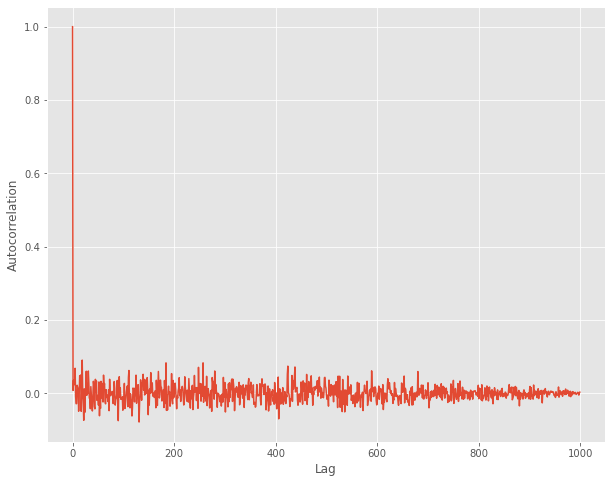

In [23]:
def plot_autocorr(x, i, method):
    if method=='maple':
        autocorr = maple_autocorr(x)
    else:
        autocorr = fft_autocorr(x)

    if i!=None:
        autocorr = autocorr[:i]
    print("autocorr len:", len(autocorr))
#     print("Autocorrelation:", autocorr)
    
    plt.plot(autocorr)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()
    
x = np.random.randn(1000)
plot_autocorr(x, None, 'maple')

In [24]:
def data_autocorr(filename, column, crop, max_lag, method):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]

    print("array len:", len(x))
    print("head values:", x[:10])
        
    plot_autocorr(x, max_lag, method)

array len: 4241739
head values: [18446744071864555537 18446744071864555537 18446744071864555537
 18446744071864555537 18446744071864555537 18446744071839879747
 18446744071832898273 18446744071832898273 18446744071832898273
 18446744071832898273]
autocorr len: 4241739


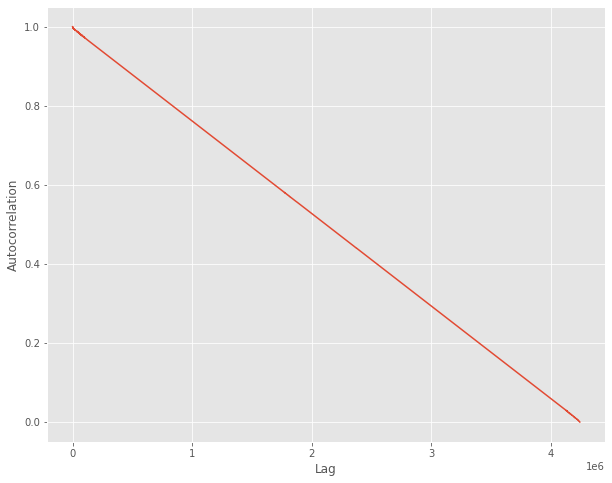

array len: 3017829
head values: [18446744071734532113 18446744071734532113 18446744071734532113
 18446744071734532113 18446744071734532113 18446744071709856323
 18446744071709857789 18446744071717303650 18446744071702874849
 18446744071710414927]
autocorr len: 3017829


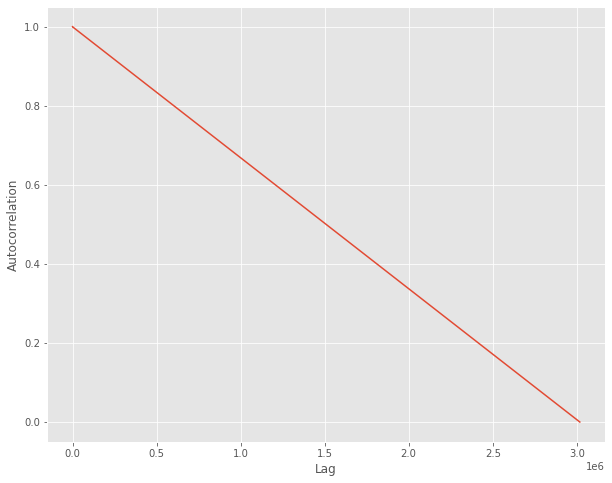

array len: 417103
head values: [4112549988 4112549988 3995109476 3709896804 4112549988 4112549988
 4112549988 4112549988 4112549988 3995109476]
autocorr len: 417103


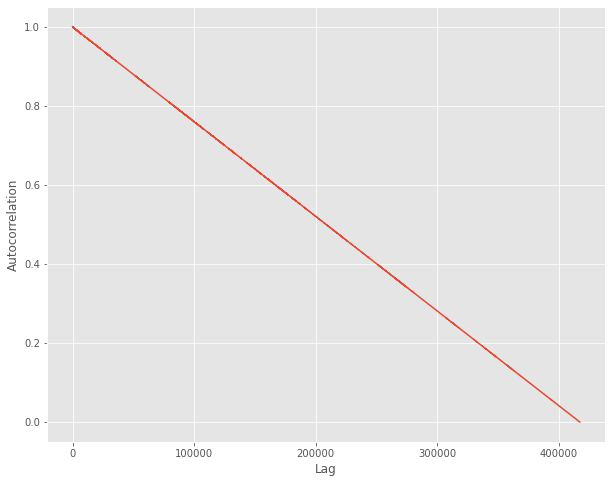

array len: 67984
head values: [18446744071952629957 18446744071952629977 18446744071952630035
 18446744071952630014 18446744071952630035 18446744071952630014
 18446744071952630035 18446744071952630014 18446744071952629966
 18446744071952630014]
autocorr len: 67984


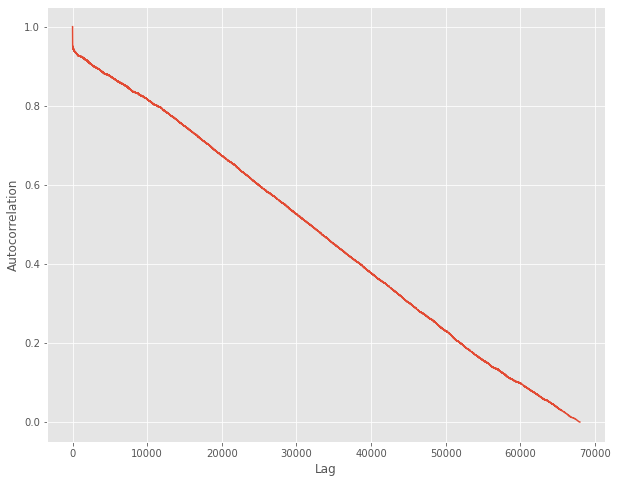

array len: 264073
head values: [17149707379558976315 17149707379558976315 17365880161672732794
 17365880161672732794 17149707379558976315 17149707379558976315
 17149707379558976315 17149707379558976315 17149707379558976315
 17149707379558976315]
autocorr len: 264073


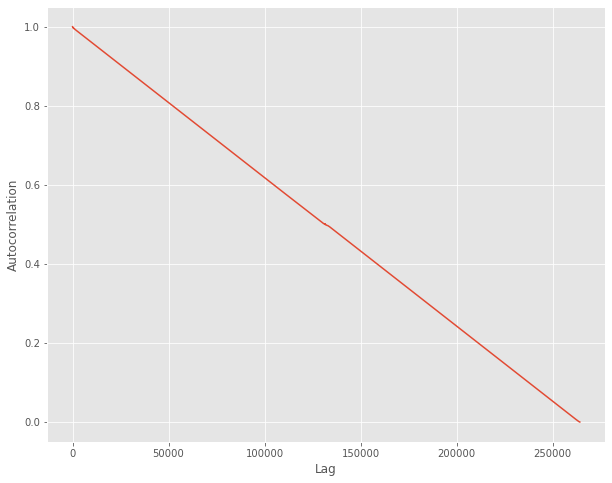

In [25]:
for file in data_files:
    data_autocorr(file, 'input2', (None, None), None, 'fft')

In [26]:
from statsmodels.graphics.tsaplots import plot_acf 

data_path = path + "\\csv\\" + data_files[0] + ".csv"
data = pd.read_csv(data_path)
x = np.array(data['input1'])

# plot_acf(x)

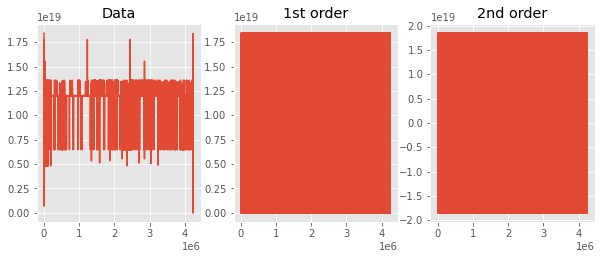

In [27]:
f = plt.figure()

ax1 = f.add_subplot(231)
ax1.set_title('Data')
ax1.plot(data.input2)

ax2 = f.add_subplot(232)
ax2.set_title('1st order')
ax2.plot(data.input2.diff())

ax3 = f.add_subplot(233)
ax3.set_title('2nd order')
ax3.plot(data.input2.diff().diff())

plt.show()

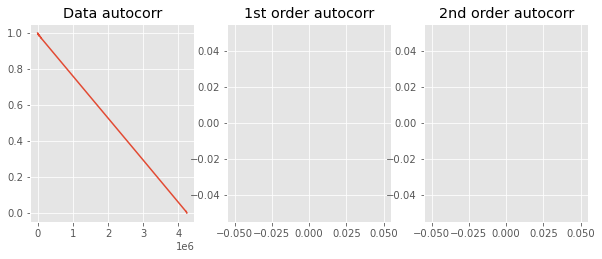

In [28]:
f = plt.figure()
ax1a = f.add_subplot(231)
ax1a.set_title('Data autocorr')
ax1a.plot(fft_autocorr(data.input2))

ax2a = f.add_subplot(232)
ax2a.set_title('1st order autocorr')
ax2a.plot(fft_autocorr(data.input2.diff()))

ax3a = f.add_subplot(233)
ax3a.set_title('2nd order autocorr')
ax3a.plot(fft_autocorr(data.input2.diff().diff()))

plt.show()

# III - 1st order differencing
## 1) Probability functions

In [29]:
def diff(df, columns):
    for col in columns:
        y = df[col].to_numpy()
        y =  y - np.roll(y.copy(), 1)
        y[0] = 0 # Should remove?
        df.loc[:, col] = y
#         return df.drop(0).reset_index(drop=True)

In [30]:
def remove_extremes(x): 
#     x = x[0 <= x]
    n = len(x)
    Q1, Q3 = np.quantile(x, [0.25, 0.75])
    IQR = Q3 - Q1
    a, b = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    
    x = x[(a <= x) & (x <= b)]
    
#     print(n-len(x), a, b)
    return x

In [31]:
def kstest_norm(x, bins):
    # Model fitting
    mu, sigma = np.mean(x), np.std(x)
    pdf_x = np.linspace(np.min(x),np.max(x), bins*10)
    pdf_y = 1.0 / np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(pdf_x - mu)**2/sigma**2)
    
    # Test
    ks_statistic, p_value = kstest(x, 'norm')
    print("\t Gauss model: mu="+str(mu)+", sigma="+str(sigma))
    print("\t KS test: statistic="+str(ks_statistic)+", pvalue="+str(p_value))
    
    return  (pdf_x, pdf_y, mu, sigma) 

In [32]:
def kstest_laplace(sample, bins):
    # Model fitting
    pdf_x = np.linspace(np.min(sample),np.max(sample), bins*10)
    
    fitter = Fitter(sample, distributions=['laplace'])
    fitter.fit()
    location, scale = fitter.fitted_param["laplace"]
    
    def cdf(x, loc, scale):
        return 1/2 * (1 + np.sign(x-loc) * (1 - np.exp(-(np.abs(x-loc)/scale))))
    
    # Test
    ks_statistic, p_value = kstest(sample, cdf, args=(location, scale))
    print("\t Exponential model: scale="+str(scale))
    print("\t KS test: statistic="+str(ks_statistic)+", pvalue="+str(p_value))
    
    return (pdf_x, cdf(pdf_x, location, scale))

In [33]:
def kstest_cauchy(sample, bins):
    # Model fitting
    pdf_x = np.linspace(np.min(sample),np.max(sample), bins*10)
    
    fitter = Fitter(sample, distributions=['cauchy'])
    fitter.fit()
    location, scale = fitter.fitted_param["cauchy"]
    
    def cdf(x, loc, scale):
        return  1/np.pi * np.arctan((x-loc)/scale) + 0.5
    
    def pdf(x, loc, scale):
        return  1/(np.pi * scale * (1 + ((x-loc)/scale)**2))
    
    # Test
    ks_statistic, p_value = kstest(sample, cdf, args=(location, scale))
    print("\t Model parameters: scale="+str(scale), "location="+str(location))
    print("\t KS test: statistic="+str(ks_statistic)+", pvalue="+str(p_value))
    
    return (pdf_x, pdf(pdf_x, location, scale))

In [34]:
def pdf(x, loc, scale):
    return  1/(np.pi * scale * (1 + ((x-loc)/scale)**2))

def get_cauchy_pdf(pdf_x, loc, scale):
    return pdf(pdf_x, loc, scale)

def pdf_mixture(pdf_x, means, scales, weights):
    n = len(pdf_x)
    pdf = np.zeros(n)
    K = len(means)
    for k in range(K):
        pdf += weights[k] * get_cauchy_pdf(pdf_x, means[k], scales[k])
    return pdf / np.sum(weights)

def log_likelihood(params, data, K):
    # Unpack parameters
    means, scales, log_weights = params[:K], params[K:2*K], params[2*K:]
    weights = np.exp(log_weights) / np.sum(np.exp(log_weights))
    
    # Compute the log-likelihood
    ll = np.sum([weights[k] * np.log(cauchy.pdf(data, loc=means[k], scale=scales[k]))
                 for k in range(K)])
    return -ll

def fit_mixture_model(sample, K, bins):
    pdf_x = np.linspace(np.min(sample),np.max(sample), bins*10)
    
    # Initialize parameters
    np.random.seed(0)
    means = np.random.randn(K)
    scales = np.random.rand(K) + 1
    log_weights = np.zeros(K)
    params = np.concatenate([means, scales, log_weights])
    
    # Minimize the negative log-likelihood
    res = minimize(log_likelihood, params, args=(sample,K,), method='Nelder-Mead')
    
    # Extract the estimated parameters
    means, scales, log_weights = res.x[:K], res.x[K:2*K], res.x[2*K:]
    weights = np.exp(log_weights) / np.sum(np.exp(log_weights))
    
    print(means)
    print(scales)
    print(weights)
    
    pdf_y = pdf_mixture(pdf_x, means, scales, weights)
    return (pdf_x, pdf_y)

## 2) Density visualisation

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h


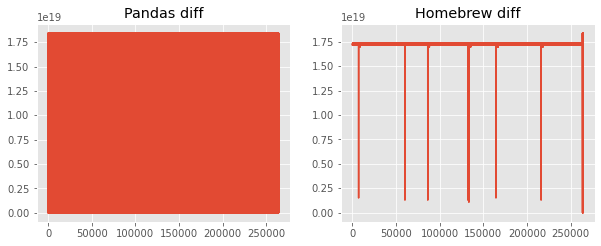

moduntu_HP_server_trace_no-wifi_22.12.20_16h


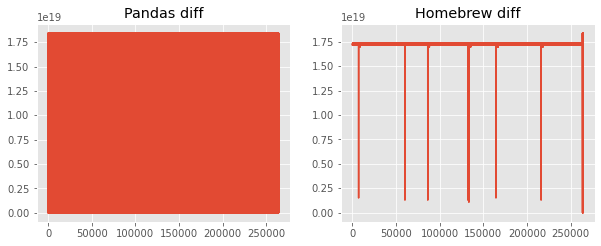

moduntu_RPi_server32_trace_no-peri_23.01.19_17h


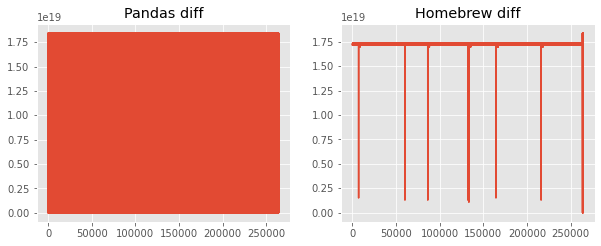

moduntu_VM_desktop_trace_no-wifi_23.01.18_14h


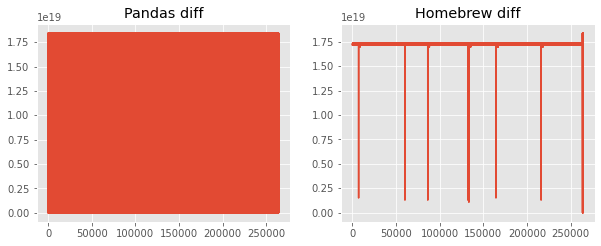

moduntu_VM_server_trace_no-wifi_23.01.18_14h


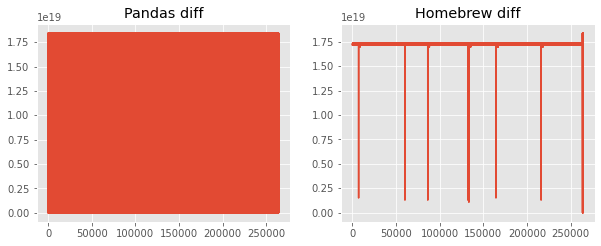

In [35]:
for file in data_files:
    print(file)
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    f = plt.figure()
    ax1 = f.add_subplot(221)
    ax1.set_title('Pandas diff')
    ax1.plot(data.input2.diff())
    
#     print("1st pd value", data.input2.diff()[0])
#     print("2nd pd value", data.input2.diff()[1])
    
    diff(data, ['input1'])
    ax2 = f.add_subplot(222)
    ax2.set_title('Homebrew diff')
    ax2.plot(data.input2)
    
#     print("1st HB value", data.input2[0])
#     print("2nd HB value", data.input2[1])
#     print()

    plt.show()

In [36]:
def data_diff_hist(filename, column, selection = [], crop = (None, None), xzoom = (None, None), log = False, 
                   bins = None, model=None, k=None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 

    # Cropping: remove crop[0] % of beginning or crop[1] of end of the data
    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))
        
    diff(data, [column])
    x = remove_extremes(data[column])
#     x = data[column]
    bins = int(np.sqrt(len(x))) if bins==None else bins
    
    # Figure
    fig, ax = plt.subplots()
#     ax = x.plot(kind='hist', bins=bins, density=True, alpha=0.5, 
#                    color=list(plt.rcParams['axes.prop_cycle'])[1]['color'], log=log)
    plt.hist(x, density=True, log = log, bins = bins)
    
    if not xzoom==(None,None):
        plt.xlim(np.min(x) if xzoom[0]==None else xzoom[0], np.max(x) if xzoom[1]==None else xzoom[1])
    
    hist, bin_edges = np.histogram(x, bins=bins) 
    prob = hist / np.sum(hist)
    entropy = -np.sum(prob * np.log2(prob + (prob==0)))
    min_entropy = -np.log2(np.max(prob))
    
    # Print info
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if not crop[0] else int(crop[0]*n))+",", str(0 if not crop[1] else int(crop[1]*n)))
    print("\t min-entropy:", min_entropy)
    print("\t entropy:", entropy)
    print("\t # of elements:", str(len(x)))
    print("\t # of bins:", str(bins))
    print("\t log =", str(log))
    print()
        
    if model=="norm": 
        pdf_x, pdf_y, mu, sigma = kstest_norm(x, bins)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='laplace':
        pdf_x, pdf_y = kstest_laplace(x, bins)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='cauchy':
        pdf_x, pdf_y = kstest_cauchy(x, bins)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="mixed": 
        pdf_x, pdf_y = fit_mixture_model(x, 1 if k==None else k, bins)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="test": 
        fitter = Fitter(x, distributions=['norm', 'laplace', 'cauchy'])
        fitter.fit()
        print(fitter.summary())
    elif model=='export':
        x.to_csv("csv/fit_results.csv")
        
    ax.set_xlabel(u'Timestamp delay')
    ax.set_ylabel('Frequency')
    
    plt.show()

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: 
	 crop values: 848347, 848347
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 2495961
	 # of bins: 500
	 log = False



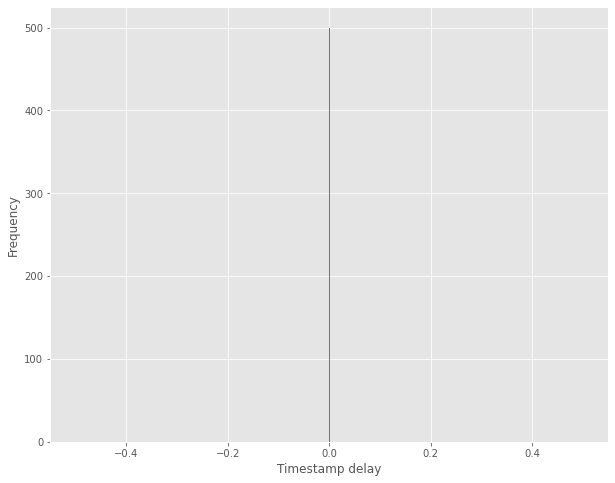

Histogram of moduntu_HP_server_trace_no-wifi_22.12.20_16h :
	 selection: 
	 crop values: 603565, 603565
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 1805757
	 # of bins: 500
	 log = False



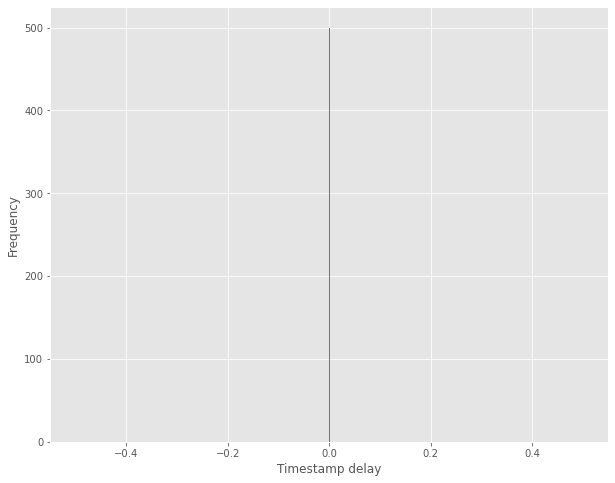

Histogram of moduntu_RPi_server32_trace_no-peri_23.01.19_17h :
	 selection: 
	 crop values: 83420, 83420
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 151808
	 # of bins: 500
	 log = False



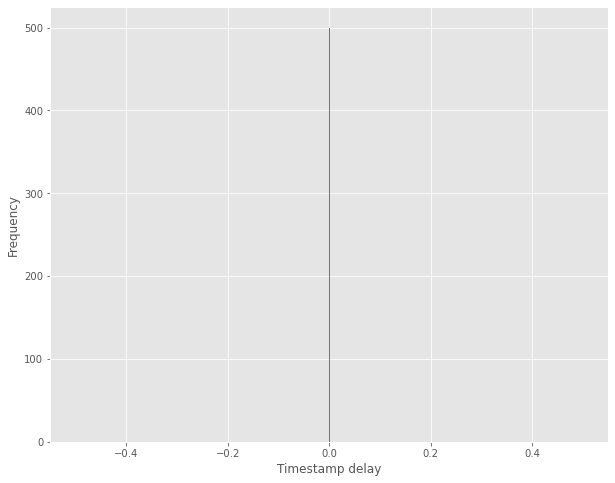

Histogram of moduntu_VM_desktop_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 13596, 13596
	 min-entropy: 0.20839086491291586
	 entropy: 1.0937156814748192
	 # of elements: 31770
	 # of bins: 500
	 log = False



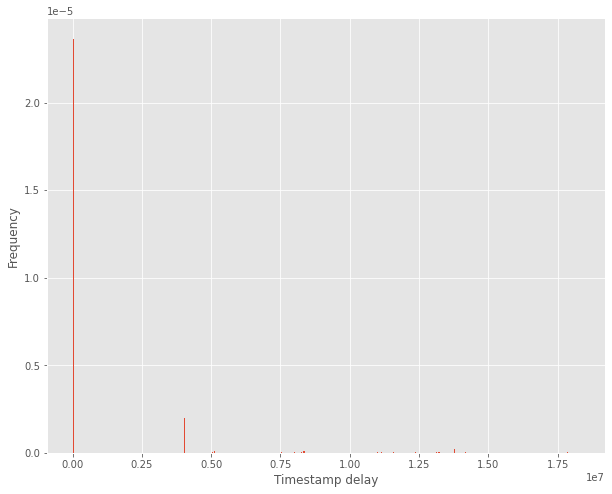

Histogram of moduntu_VM_server_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 52814, 52814
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 120368
	 # of bins: 500
	 log = False



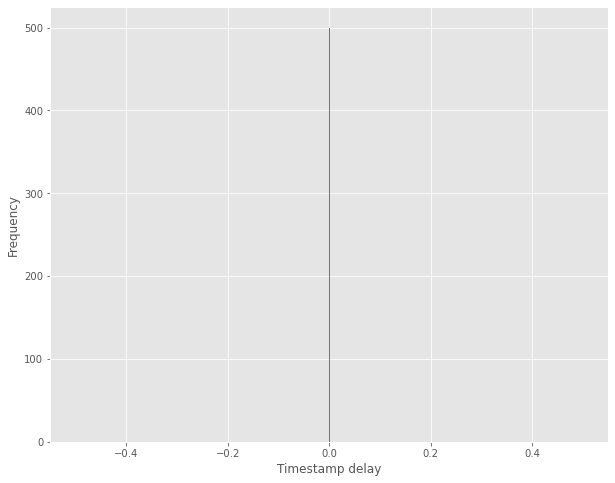

In [37]:
for file in data_files:
    data_diff_hist(file, 'input2', selection = [], 
                   crop = (0.2, 0.2), log = False, bins = 500, model=None)

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: 
	 crop values: 848347, 848347
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 2495961
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.34s/it]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


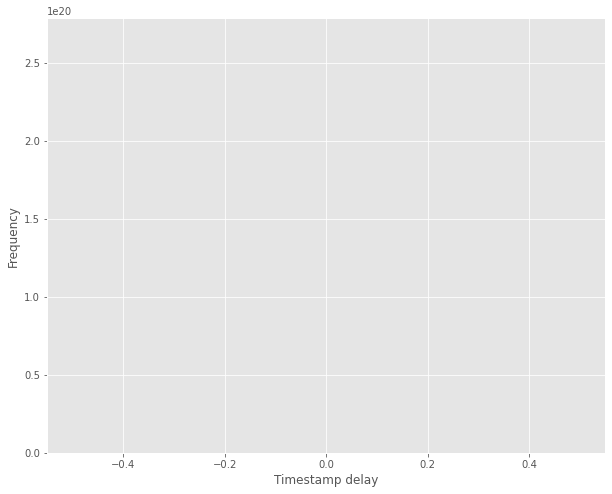

Histogram of moduntu_HP_server_trace_no-wifi_22.12.20_16h :
	 selection: 
	 crop values: 603565, 603565
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 1805757
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.01s/it]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


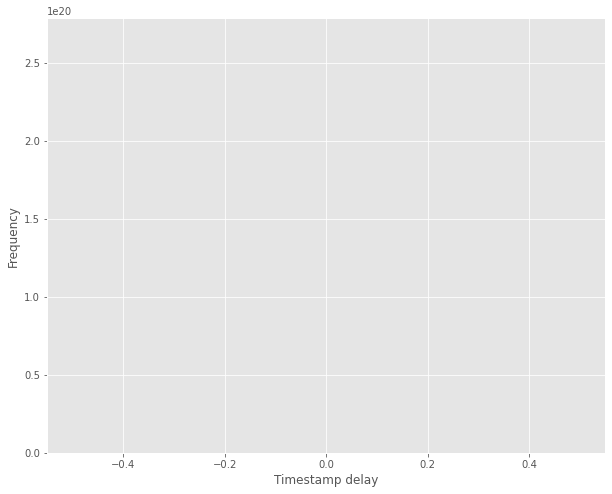

Histogram of moduntu_RPi_server32_trace_no-peri_23.01.19_17h :
	 selection: 
	 crop values: 83420, 83420
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 151808
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


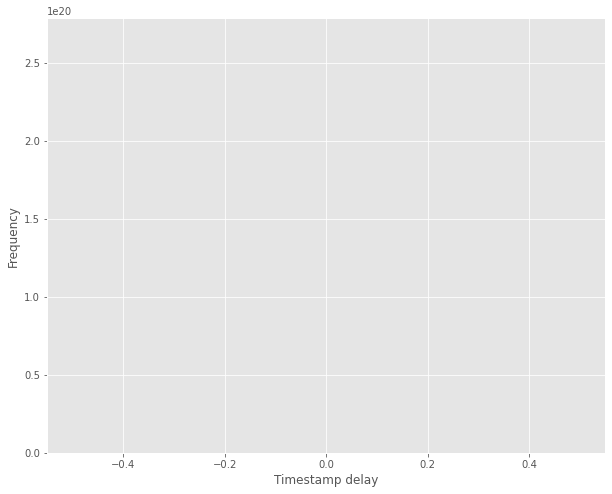

Histogram of moduntu_VM_desktop_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 13596, 13596
	 min-entropy: 0.20839086491291586
	 entropy: 1.0937156814748192
	 # of elements: 31770
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.39it/s]

	 Model parameters: scale=1.4801248126287263e-21 location=-3.6140173727098604e-22
	 KS test: statistic=0.5762300950679708, pvalue=0.0


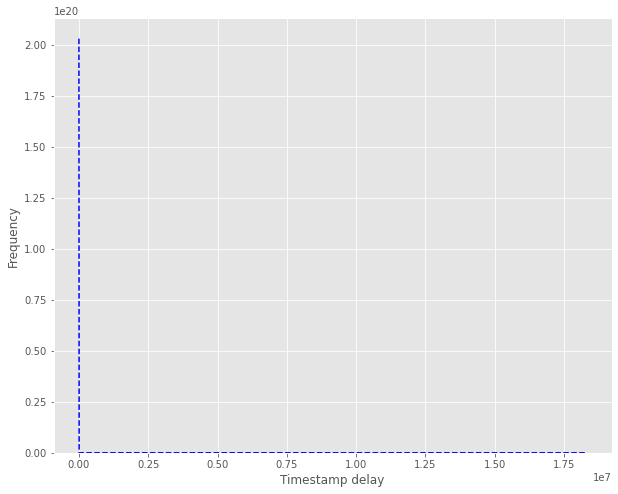

Histogram of moduntu_VM_server_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 52814, 52814
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 120368
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


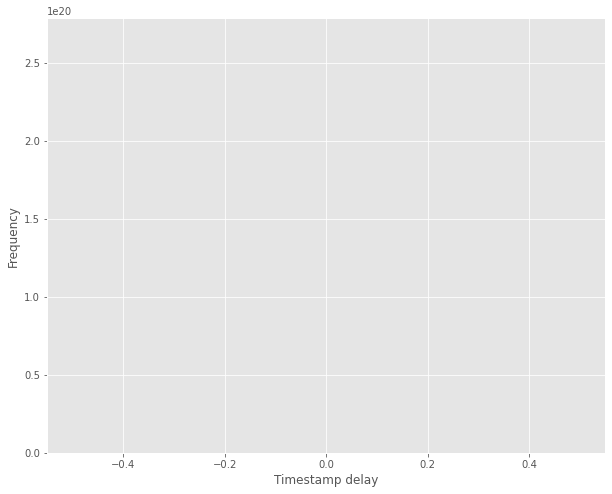

In [38]:
for file in data_files:
    data_diff_hist(file, 'input2', selection = [], 
                   crop = (0.2, 0.2), log = False, bins = 500, model="cauchy", k=1)

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: 
	 crop values: 848347, 848347
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 2495961
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.81s/it]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


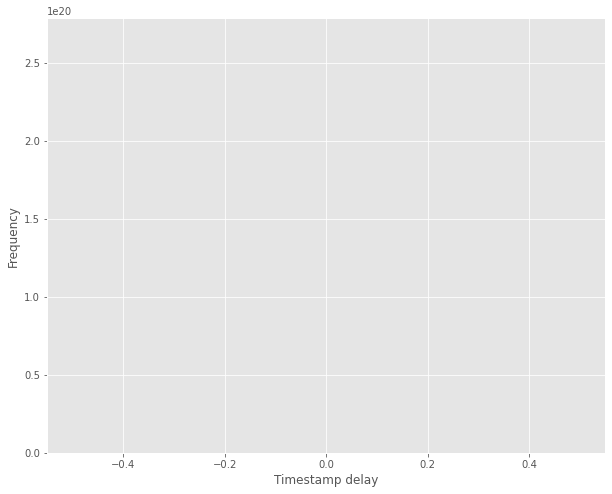

Histogram of moduntu_HP_server_trace_no-wifi_22.12.20_16h :
	 selection: 
	 crop values: 603565, 603565
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 1805757
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.07s/it]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


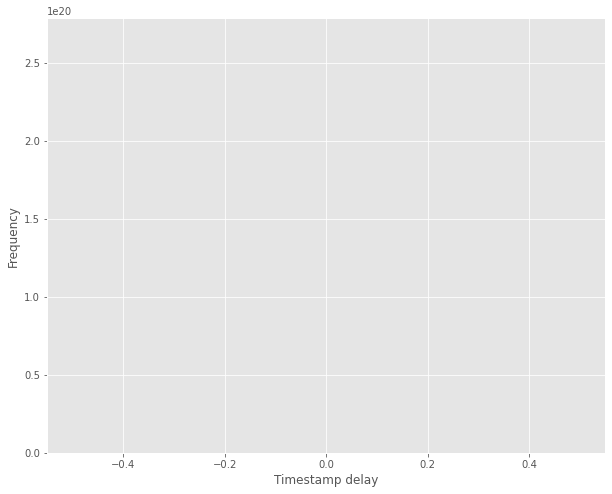

Histogram of moduntu_RPi_server32_trace_no-peri_23.01.19_17h :
	 selection: 
	 crop values: 83420, 83420
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 151808
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


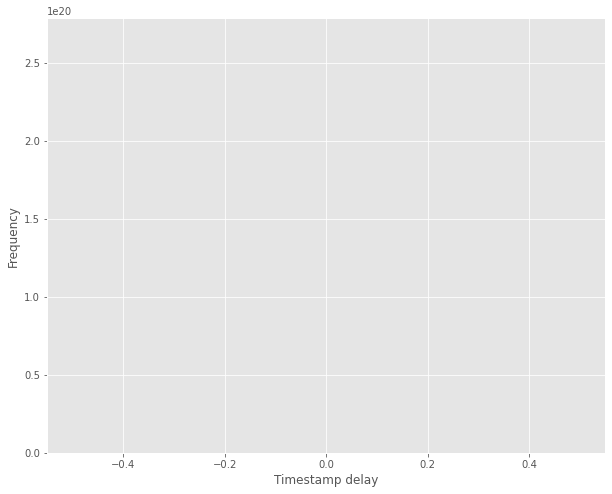

Histogram of moduntu_VM_desktop_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 13596, 13596
	 min-entropy: 0.20839086491291586
	 entropy: 1.0937156814748192
	 # of elements: 31770
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.03it/s]

	 Model parameters: scale=1.4801248126287263e-21 location=-3.6140173727098604e-22
	 KS test: statistic=0.5762300950679708, pvalue=0.0


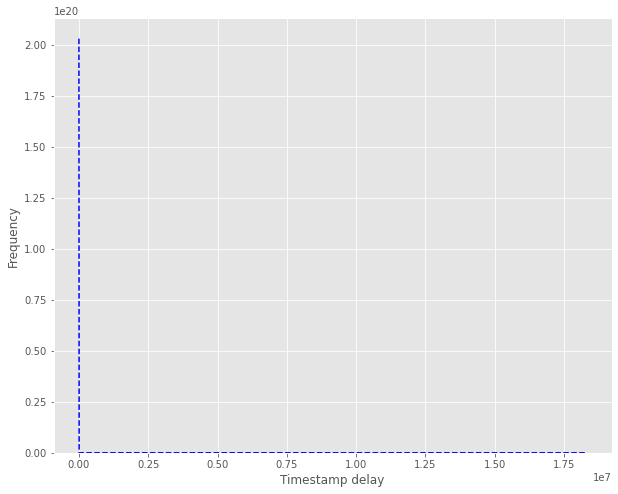

Histogram of moduntu_VM_server_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 52814, 52814
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 120368
	 # of bins: 500
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


	 Model parameters: scale=1.0222752140557587e-21 location=-4.2443431331503575e-22
	 KS test: statistic=0.6252641034637925, pvalue=0.0


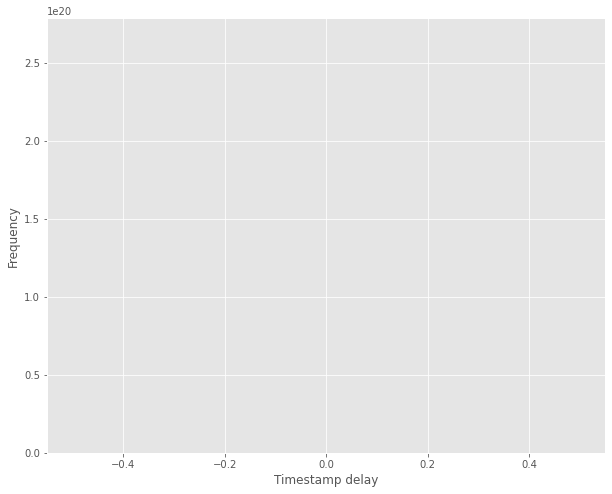

In [39]:
for file in data_files:
    data_diff_hist(file, 'input2', selection = [], 
                   crop = (0.2, 0.2), log = False, bins = 500, model="cauchy")

## 2) Independence of inputs
### A/ Autocorrelation coefficient

In [40]:
def data_diff_autocorr(filename, column, crop, max_lag, method):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    diff(data, [column])
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]
    
    print("array len:", len(x))
    print("head values:", x[:10])
    
    plot_autocorr(x, max_lag, method)

array len: 42417
head values: [0 0 0 0 0 0 0 0 0 0]
autocorr len: 42417


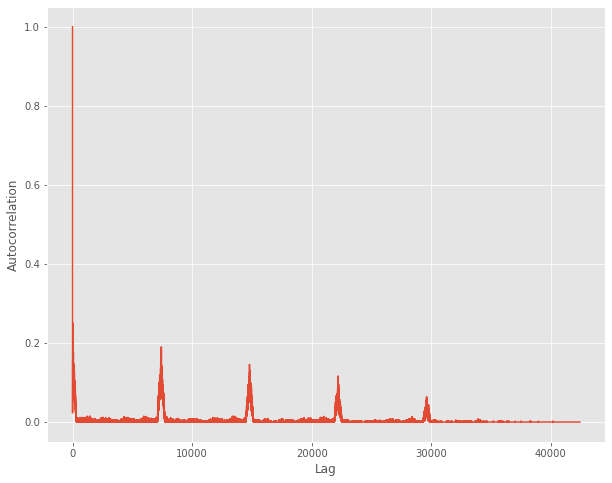

array len: 30178
head values: [0 0 0 0 0 0 0 0 0 0]
autocorr len: 30178


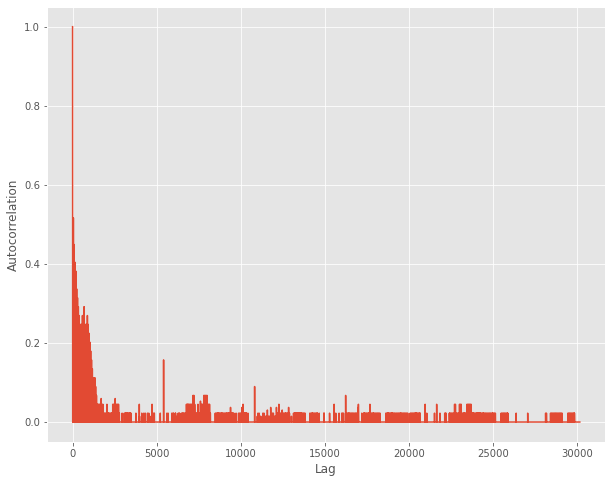

array len: 4171
head values: [         0          0          0          0 -117440512 -285212672
  402653184          0          0          0]
autocorr len: 4171


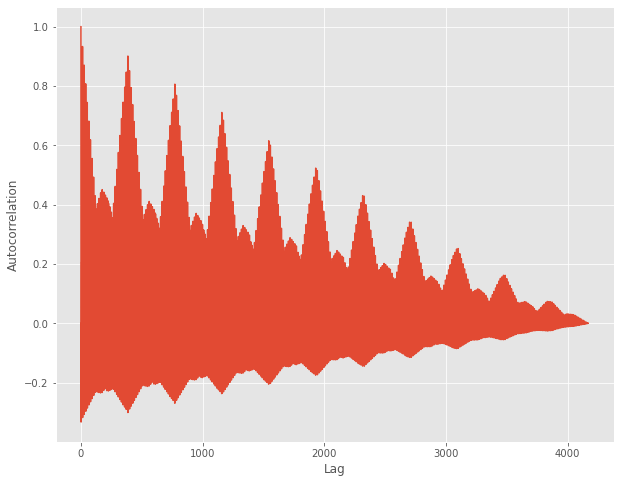

array len: 680
head values: [                   0                    0 18446744073002640547
                    0 18446744073709551263                    0
                    0                    0                    0
                    0]
autocorr len: 680


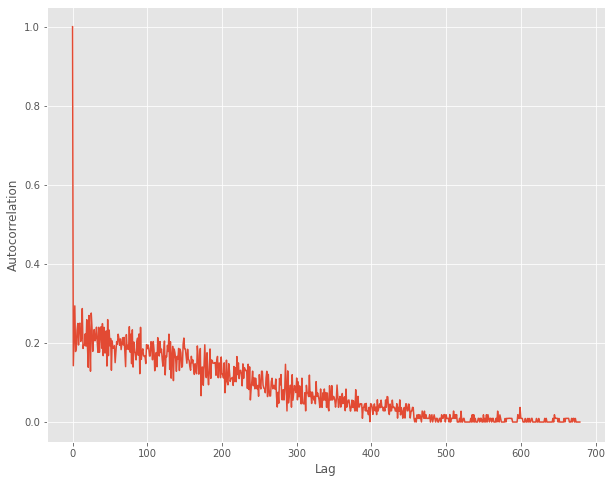

array len: 2641
head values: [                   0                    0                    0
                    0                    0                    0
            400982060 18446744073308569556   216172782113788570
                    0]
autocorr len: 2641


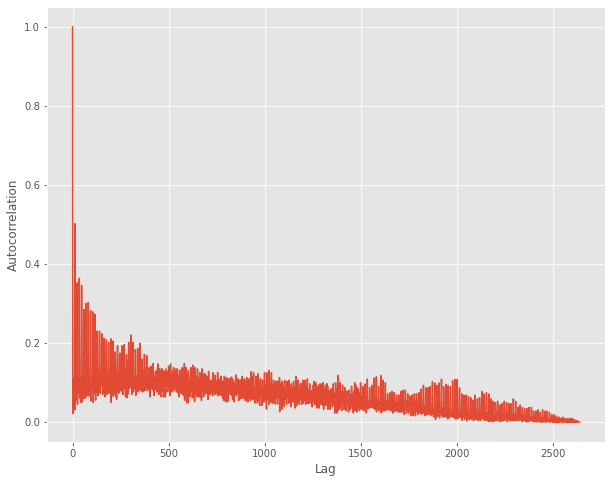

In [41]:
for file in data_files:
    data_diff_autocorr(file, 'input2', (0.49, 0.50), None, 'fft')

# III - 2nd order differencing
## 1) Density visualization

In [42]:
def data_double_diff_hist(filename, column, selection = [], crop = (None, None), xzoom = (None, None), log = False, 
                   bin_n = None, model=None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 
        
    diff(data, [column])
    diff(data, [column])

    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))

#     x = np.array(data[column])
    x = np.array(remove_extremes(data[column]))
    bin_n = int(np.sqrt(len(x)))
    print(bin_n)
    
    # Figure
    fig, ax = plt.subplots()
    hist_prob, bins, patches = plt.hist(x, density=True, log=log, bins=bin_n)
    prob = hist_prob / np.sum(hist_prob)
    entropy = -np.sum(prob * np.log2(prob + (prob==0)))
    min_entropy = -np.log2(np.max(prob))
    
#     hist, bin_edges = np.histogram(x, bins=bin_n) 
#     prob2 = hist / np.sum(hist)
#     min_entropy2 = -np.log2(np.max(prob))
#     entropy2 = -np.sum(prob * np.log2(prob + (prob==0)))
#     print("entropy 2:", entropy2, "min-entropy2:", min_entropy2)
#     ax.bar(bin_edges[:-1], prob, width=(bin_edges[1] - bin_edges[0]))
#     plt.hist(x, density=True, log = log, bins = bin_n)
    
    if not xzoom==(None,None):
        plt.xlim(np.min(x) if xzoom[0]==None else xzoom[0], np.max(x) if xzoom[1]==None else xzoom[1])
    
    # Print info
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if crop[0]==None else str(crop[0]*n))+",", 
          str(0 if crop[1]==None else str(crop[1]*n)))
    print("\t min-entropy:", min_entropy)
    print("\t entropy:", entropy)
    print("\t # of elements:", str(len(x)))
    print("\t # of bins:", str(bin_n))
    print("\t log =", str(log))
    print()
    
    
    if model=="norm": 
        pdf_x, pdf_y, mu, sigma = kstest_norm(x, bin_n)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='laplace':
        pdf_x, pdf_y = kstest_laplace(x, bin_n)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='cauchy':
        pdf_x, pdf_y = kstest_cauchy(x, bin_n)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="mixed": 
        pdf_x, pdf_y = fit_mixture_model(x, 1 if k==None else k, bins)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="test": 
        fitter = Fitter(x, distributions=['norm', 'laplace', 'cauchy'])
        fitter.fit()
        print(fitter.summary())
    elif model=='export':
        x.to_csv("csv/fit_results.csv")
        
    ax.set_xlabel(u'Timestamp double differential')
    ax.set_ylabel('Frequency')
    
    plt.show()

1812
Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: 
	 crop values: 848347.8, 0
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 3285270
	 # of bins: 1812
	 log = False



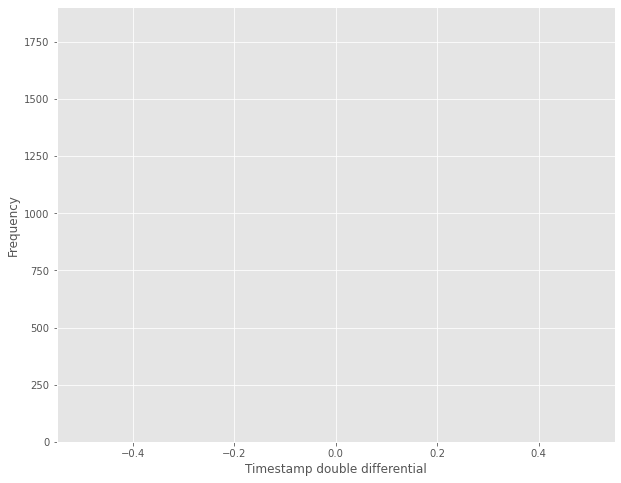

1550
Histogram of moduntu_HP_server_trace_no-wifi_22.12.20_16h :
	 selection: 
	 crop values: 603565.8, 0
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 2404871
	 # of bins: 1550
	 log = False



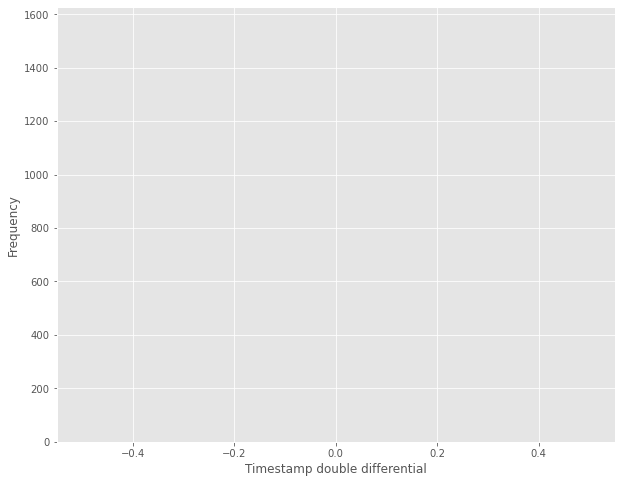

511
Histogram of moduntu_RPi_server32_trace_no-peri_23.01.19_17h :
	 selection: 
	 crop values: 83420.6, 0
	 min-entropy: 0.7787590252671396
	 entropy: 1.6795033234043413
	 # of elements: 261253
	 # of bins: 511
	 log = False



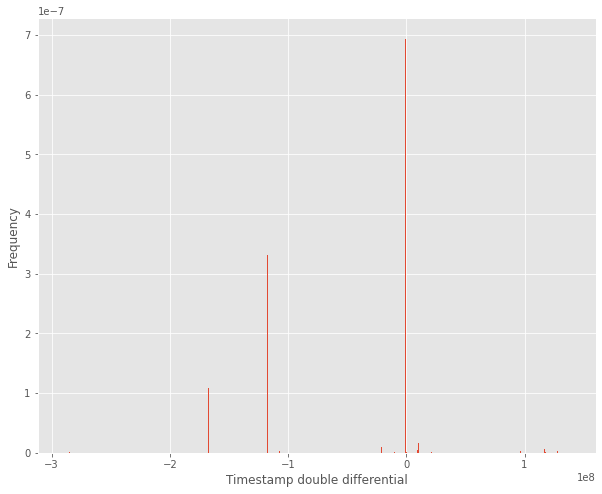

202
Histogram of moduntu_VM_desktop_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 13596.800000000001, 0
	 min-entropy: 0.16746867536397148
	 entropy: 0.817741166825314
	 # of elements: 40932
	 # of bins: 202
	 log = False



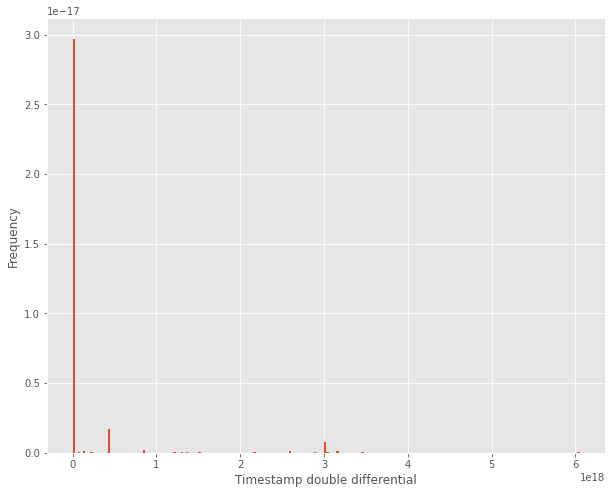

408
Histogram of moduntu_VM_server_trace_no-wifi_23.01.18_14h :
	 selection: 
	 crop values: 52814.600000000006, 0
	 min-entropy: 0.35008316426373265
	 entropy: 0.8086417025393919
	 # of elements: 166689
	 # of bins: 408
	 log = False



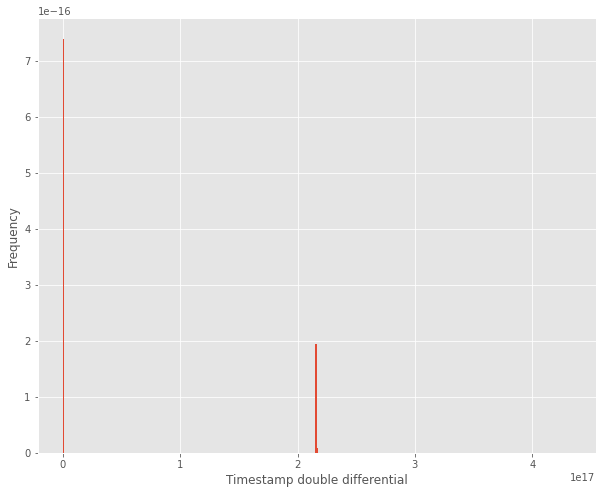

In [43]:
for file in data_files:
    data_double_diff_hist(file, 'input2', crop = (0.2, None))

1813
Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: 
	 crop values: 424173.9, 424173.9
	 min-entropy: -0.0
	 entropy: -0.0
	 # of elements: 3287294
	 # of bins: 1813
	 log = False



Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.03s/it]


KeyError: 'cauchy'

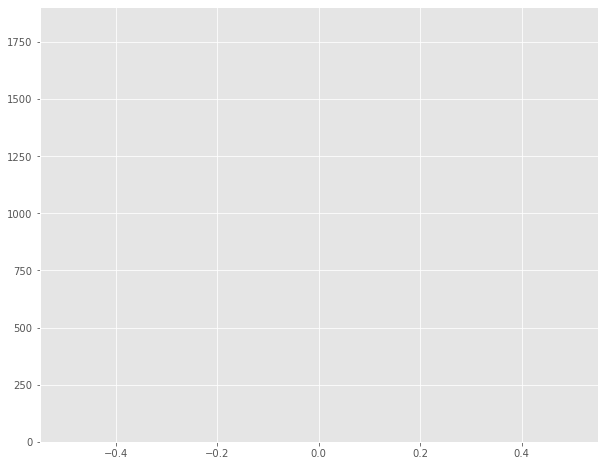

In [44]:
for file in data_files:
    data_double_diff_hist(file, 'input2', crop = (0.1, 0.1), model="cauchy")

## 2) Entropy estimation

In [ ]:
def histogram_entropy_estimation(filename, column, selection, crop, bins, order):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 
    
    for i in range(order):
        diff(data, [column])
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]
    
    hist, bin_edges = np.histogram(x, bins=bins) 
    prob = hist / np.sum(hist)
    entropy = -np.sum(prob * np.log2(prob + (prob==0)))
    min_entropy = -np.log2(np.max(prob))
    
    print(filename)
    print('\t entropy', entropy)
    print('\t min_entropy', min_entropy)

In [ ]:
histogram_entropy_estimation(data_files[0], 'input2', [], (0.2,None), 1000, 0)
histogram_entropy_estimation(data_files[0], 'input2', [], (0.2,None), 1000, 1)
histogram_entropy_estimation(data_files[0], 'input2', [], (0.2,None), 1000, 2)

## 2) Independence of inputs
### A/ Autocorrelation coefficient

In [ ]:
def data_double_diff_autocorr(filename, column, crop, max_lag, method):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    diff(data, [column])
    diff(data, [column])
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]

    print("array len:", len(x))
    print("head values:", x[:10])
        
    plot_autocorr(x, max_lag, method)

In [ ]:
for file in data_files:
    data_double_diff_autocorr(file, 'input2', (None, None), None, 'fft')

### Proof of concept

In [ ]:
data_path = path + "\\csv\\" + data_files[0] + ".csv"
data = pd.read_csv(data_path)

diff(data, ['input2'])
diff(data, ['input2'])
x = np.array(data['input2'])
# x = np.array(remove_extremes(data['input2']))
bins = 1000
log = False


def compute_entropy(prob):
    return -np.sum(prob * np.log2(prob + (prob==0)))

def min_entropy(prob):
    return -np.log2(np.max(prob))


fig, ax = plt.subplots()
n, bins, patches = plt.hist(x, density=True, log=log, bins=bins)

# # Calculate the probability
prob1 = n / np.sum(n)
entropy1 = compute_entropy(prob1)
min_entropy1 = min_entropy(prob1)

# Compute the density distribution and entropy level using numpy
hist, bin_edges = np.histogram(x, bins=bins)

# Calculate the probability
prob2 = hist / np.sum(hist)
entropy2 = compute_entropy(prob2)
min_entropy2 = min_entropy(prob2)

# fig, ax = plt.subplots()
# ax.bar(bin_edges[:-1], prob2, width=(bin_edges[1] - bin_edges[0]))

print("Matplotlib entropy:", entropy1, "Min-entropy:", min_entropy1)
print("NumPy entropy:", entropy2, "Min-entropy:", min_entropy2)

In [ ]:
import math

def cauchy_cdf(g, x0, x):
    r = (1.0 / math.pi) * math.atan((x - x0) / g) + 0.5
    if 0.0 < r <= 1.0:
        return r
    else:
        return 0.0
    
def cauchy_pdf(g, x0, x):
    r = 1 / (math.pi * g * (1 + ((x - x0) / g) ** 2))
    if 0.0 < r <= 1.0:
        return r
    else:
        return 0.0
    
def compute_entropy(probs):
    num_bins = int(math.sqrt(len(probs)))
    binned_probs = bin_probabilities(probs, num_bins)
    return -np.sum(binned_probs * np.log2(binned_probs + np.finfo(float).eps))

def min_entropy(probs):
    num_bins = int(math.sqrt(len(probs)))
    binned_probs = bin_probabilities(probs, num_bins)
    return -np.log2(np.max(binned_probs))

def bin_probabilities(probabilities, num_bins):
    step = len(probabilities) // num_bins
    binned_probabilities = [sum(probabilities[i * step:(i + 1) * step]) for i in range(num_bins)]
    return np.array(binned_probabilities)
    
params = (200,0)
discrete_range = np.arange(0, 2**16)

prob_pdf = np.array([cauchy_pdf(params[0], params[1], x) 
                    for x in discrete_range])
prob_cdf = np.array([cauchy_cdf(params[0], params[1], x+0.5) - cauchy_cdf(params[0], params[1], x-0.5) 
                    for x in discrete_range])

prob_pdf = prob_pdf/np.sum(prob_pdf)
prob_cdf = prob_cdf/np.sum(prob_cdf)

entropy1 = compute_entropy(prob_pdf)
min_entropy1 = min_entropy(prob_pdf)
print("PDF entropy:", entropy1, "Min-entropy:", min_entropy1)

entropy2 = compute_entropy(prob_cdf)
min_entropy2 = min_entropy(prob_cdf)
print("CDF entropy:", entropy1, "Min-entropy:", min_entropy1)

fig, ax = plt.subplots()
ax.plot(prob_cdf)
ax.plot(prob_pdf)
plt.show()